<a href="https://colab.research.google.com/github/abazabaaa/colab_tutorial/blob/main/getting_started_with_rdkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
!curl -L $url | tar xj lib
!mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.6/dist-packages/
x86 = '/usr/lib/x86_64-linux-gnu'
!mv lib/*.so.* $x86/
!ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1
import sys
sys.path.append('/usr/local/lib/python3.6/dist-packages/')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3717    0  3717    0     0  14519      0 --:--:-- --:--:-- --:--:-- 14519
100 20.2M  100 20.2M    0     0  4436k      0  0:00:04  0:00:04 --:--:-- 4768k
mv: cannot move 'lib/python3.6/site-packages/rdkit' to '/usr/local/lib/python3.6/dist-packages/rdkit': Directory not empty
ln: failed to create symbolic link '/usr/lib/x86_64-linux-gnu/libboost_python3.so.1.65.1': File exists


In [6]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

Now that we have made it past install... Lets convert a smiles string into an image we are familiar with.

A SMILES string is a way of depicting a molecular graph with a **string**.

Within python, a **string** is simply a series of letters, numbers, and symbols. Strings can be used to encode information such as a location of a file, a place in time and space, or in this case -- how a molecule is put together.

There are several kinds of **strings** that useful to for encoding molecules and I have included links to papers describing them. There is a deal of debate about which is best, but that is beyond the scope of our tutorial today.

SMILES:
https://pubs.acs.org/doi/10.1021/ci00057a005

SELFIES:
https://iopscience.iop.org/article/10.1088/2632-2153/aba947

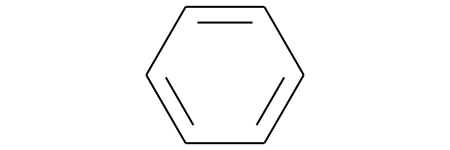

In [7]:
## We can break the code down into pieces "Chem" is responsible for calling an
## RDKit module. "MolFromSmiles" issues a command to run a module within RDKit.
## ('c1ccccc1') is used to tell "MolFromSmiles" what smiles needs to be 
## converted.

Chem.MolFromSmiles('c1ccccc1')

In [8]:
pip install py3Dmol

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True

import py3Dmol
import matplotlib.pyplot as plt
import subprocess

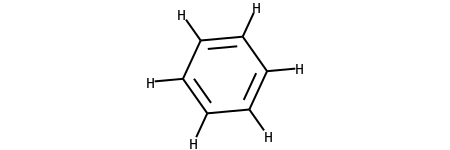

In [12]:
## Set our 2d graph of benzene equal to "mol"
mol1 = Chem.MolFromSmiles('c1ccccc1')

## Add explicit hydrogens (it will need this in order to be a real 3d molecule)
mol1 = Chem.AddHs(mol1)

## Embed the 3d structure in the "mol" we created.
AllChem.EmbedMolecule(mol1)

## Use the MMFF to optimize the geometry
AllChem.MMFFOptimizeMolecule(mol1)

## Use RDkit to see a simple representation
mol1

In [13]:
## create a function that allows us to view the molecule in a more useful format.
## don't worry too much about what the code does here, we will learn more later.
def write_xyz(mol, file_name='temp.xyz'):
  number_of_atoms = mol.GetNumAtoms()
  symbols = [a.GetSymbol() for a in mol.GetAtoms()] 
  with open(file_name, "w") as file:
    file.write(str(number_of_atoms)+"\n")
    file.write("title\n")
    conf = mol.GetConformers()[0]
    for atom,symbol in enumerate(symbols):
      p = conf.GetAtomPosition(atom)
      line = " ".join((symbol,str(p.x),str(p.y),str(p.z),"\n"))
      file.write(line)

def show_mol(file_name, animate=False):
  xyz=open(file_name, 'r').read()
  p = py3Dmol.view(width=400,height=400)
  if animate:
    p.addModelsAsFrames(xyz,'xyz')
    p.animate({'loop': "forward",'reps': 5})
    #p.animate({'loop': 'backAndForth'})
  else:
    p.addModel(xyz,'xyz')
  p.setStyle({'stick':{}})
  p.setBackgroundColor('0xeeeeee')
  p.zoomTo()
  p.show()

## Use the function to view our molecule
write_xyz(mol1, file_name='temp.xyz')
show_mol('temp.xyz', animate=False)

## You should see a 3d molecule below!

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [14]:
## This will be where you put the smiles string of interest.
## Try putting your own in from chemdraw.
smiles_string = 'CCN(CC)C(=O)C1CN(C2CC3=CNC4=CC=CC(=C34)C2=C1)C'

## Pass in your smiles_string to the conversion function
two_dimensional_molecule = Chem.MolFromSmiles(smiles_string)

## pass in your 2d molecule to sprout explicit hydrogen
two_dimensional_molecule_with_hydrogen = Chem.AddHs(two_dimensional_molecule)

## Embed the 3d structure in the "mol" we created.
AllChem.EmbedMolecule(two_dimensional_molecule_with_hydrogen)
AllChem.MMFFOptimizeMolecule(two_dimensional_molecule_with_hydrogen)

## Have a look at the molecule!
write_xyz(two_dimensional_molecule_with_hydrogen, file_name='new_mol.xyz')
show_mol('new_mol.xyz', animate=False)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Usually we want to be able to get an optimized structure back. The structure above may not be complete optimized and in a low energy state. Lets make a function to scan for the lowest energy state.

In [15]:
def get_best_structure(mol,n_confs=10):
  new_mol = Chem.Mol(mol)

  AllChem.EmbedMultipleConfs(mol,numConfs=n_confs,useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
  energies = AllChem.MMFFOptimizeMoleculeConfs(mol,maxIters=2000, nonBondedThresh=100.0)

  energies_list = [e[1] for e in energies]
  min_e_index = energies_list.index(min(energies_list))

  new_mol.AddConformer(mol.GetConformer(min_e_index))

  return new_mol

In [21]:
smiles_string = 'CCN(CC)C(=O)C1CN(C2CC3=CNC4=CC=CC(=C34)C2=C1)C'

## Pass in your smiles_string to the conversion function to make it a "mol"
two_dimensional_molecule = Chem.MolFromSmiles(smiles_string)

## pass in your 2d molecule to sprout explicit hydrogen
two_dimensional_molecule_with_hydrogen = Chem.AddHs(two_dimensional_molecule)

##Use your new function minimize the structure you have created
minimized_structure = get_best_structure(two_dimensional_molecule_with_hydrogen, n_confs=10)

##Look at the minimized structure
write_xyz(minimized_structure, file_name='new_mol1.xyz')
show_mol('new_mol1.xyz', animate=False)

##Also show the non-optimized structure
write_xyz(two_dimensional_molecule_with_hydrogen, file_name='new_mol2.xyz')
show_mol('new_mol2.xyz', animate=False)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol